## Comparing CEMS API and MLAS / geolib algorithms

A work in progress notebook to compare CEMS API and MLAS / Geolib

In [55]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

from mlasengine.helpers import case_insensitive_glob, soilcode_to_parameters, longcode_to_shortcode
from mlasengine.objects.cpt import CPT, CPTConversionMethod
from mlasengine.objects.borehole import Borehole

from nuclei import call_endpoint
APP = 'gef-model'

Read the CPTs and boreholes and differentiate in crest / polder in a nasty way

In [78]:
cptfiles_crest = [f for f in case_insensitive_glob("D:/_TEMP/P1011", ".gef") if str(f).find('cpts')>-1 and str(f).find('kruin')>-1]
boreholefiles_crest = [f for f in case_insensitive_glob("D:/_TEMP/P1011", ".gef") if str(f).find('boreholes')>-1 and str(f).find('kruin')>-1]
cptfiles_polder = [f for f in case_insensitive_glob("D:/_TEMP/P1011", ".gef") if str(f).find('cpts')>-1 and str(f).find('polder')>-1]
boreholefiles_polder = [f for f in case_insensitive_glob("D:/_TEMP/P1011", ".gef") if str(f).find('boreholes')>-1 and str(f).find('polder')>-1]

Fill in the required payload information but without the CPT data

In [79]:
schema = {
  "aggregate_layers_penalty": 3,
  "aggregation_loss": "l1",
  "include_features": True,
  "include_location": True,
  "merge_nen_table": True,
  "interpolate_nen_table_values": True,
  "overwrite_groundwaterlevel": -5
}

**CRUX** I am not sure if the average geotechnical engineer would be interested (or knowledgeable) about the loss function for the ML model. So maybe it could be explained in a more geotechnical way?

**CRUX** Ritchie send me a jupyter notebook where the obsolete param "n_clusters": 3 is still used, could be removed from future versions in case you send this (helpful!) notebook to clients


Use the API but only once and store the API return data. Made a copy paste later for the polder comparison as well..

In [ ]:
USE_API = False

mlas_boreholes_crest = [Borehole.from_file(f) for f in boreholefiles_crest]
mlas_cpts_crest = []
for f in cptfiles_crest:
    # use MLAS function for comparison
    cpt = CPT.from_file(f)

    # read the cpt content which is needed for the API
    with open(f, 'r') as file:
        schema["cpt_content"] = file.read()

    if USE_API:
        # call the endpoint using the classify endpoint
        result = call_endpoint(APP, '/classify', schema)

        # store the result so we don't have to spam the API
        df = pd.DataFrame(result['layer_table'])
        df.to_csv(f"D:/_TEMP/P1011/{cpt.name}.csv")
    
    # save the mlas based cpt
    mlas_cpts_crest.append(cpt)
    
mlas_boreholes_polder = [Borehole.from_file(f) for f in boreholefiles_polder]
mlas_cpts_polder = []
for f in cptfiles_polder:
    # use MLAS function for comparison
    cpt = CPT.from_file(f)

    # read the cpt content which is needed for the API
    with open(f, 'r') as file:
        schema["cpt_content"] = file.read()

    if USE_API:
        # call the endpoint using the classify endpoint
        result = call_endpoint(APP, '/classify', schema)

        # store the result so we don't have to spam the API
        df = pd.DataFrame(result['layer_table'])
        df.to_csv(f"D:/_TEMP/P1011/{cpt.name}.csv")
    
    # save the mlas based cpt
    mlas_cpts_polder.append(cpt)
    


**CRUX** no way to use the API with credentials in the POST payload?

**CRUX** got result 
```
[
    (-3.6599991201, 'Vk1'), 
    (-4.9199686446, 'Vk4'), 
    (-5.2699590872, 'Ks2'), 
    (-6.9198796081000005, 'Ks3z1'), 
    (-9.4198070717, 'Vk6'), 
    (-10.0697814307, 'Zs2k1'), 
    (-10.7697504162, 'Zs1'), 
    (-11.2697230955, 'Zs2'), 
    (-11.9496832341, 'Zs2')
]```

The last two soillayers could / should be concatenated?

**MLAS** CPT angle is not taken into account if no corrected depth is available, should be implemented

**CRUX** would be nice to have top and bottom of the layer in the output now it is 'complicated' because the top of the first layer seems to be calculated from elevation_with_respect_to_NAP + depth_top which is a bit confusing

**CRUX** question to Martina about the previous point (how to find the top of the first layer, right interpretation?)

To get a nice comparison I will convert the default MLAS colors / names to names that come close(r) to the CEMS names.

In [81]:
SOILCODESWAP_RF = {
    'nl_veen':'Vk1',
    'nl_grof_zand':'ZZUG',
    'nl_middelmatig_zand':'ZZMG',
    'nl_fijn_zand':'ZZZF',
    'nl_siltig_zand':'Zs3',
    'nl_kleiig_zand':'Zs2k2',
    'nl_zandige_klei':'Kz2',
    'nl_siltige_klei':'Ks3',
    'nl_klei':'Ks1z1',
    'nl_venige_klei':'Kv2'
}

SOILCODESWAP_THREETYPE = {
    'clay':'Ks1z1',
    'peat':'Vk1',
    'sand':'ZZMG'
}

SOILCODESWAP_SBT = {
    "sensitive_fine_grained":'Zs3',
    "organic_soils_clay":'Ks1z1',
    "clays_silty_clay_to_clay":'Ks3',
    "silt_mixtures_clayey_silt_to_silty_clay":'Ks2z2',
    "sand_mixtures_clean_sand_to_silty_sand":'Zs2',
    "sand_sensitive_fine_grained":'ZZZF',
    "gravelly_sand_to_dense_sand":'ZZMG',
    "very_stiff_sand_to_clayey_sand":'ZZUG',
    "very_stiff_fine_grained":'ZZZF'
}

Some code to plot the comparison.. started with two plots.. became 5 plots so don't mind the repeats

In [82]:
def compare_plot(soillayers_cems, soillayers_mlas_nl_rf, soillayers_mlas_threetype, soillayers_mlas_sbt, closest_borehole_info, cpt_bottom, cpt_name):
    cpt_top = max([s[0] for s in soillayers_cems + soillayers_mlas_nl_rf])
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15,5), gridspec_kw={'width_ratios': [1, 1, 1, 1, 4]})
        
    for i in range(0, len(soillayers_cems)):
        top, soilcode = soillayers_cems[i]        
        if i==len(soillayers_cems)-1:
            bottom = cpt_bottom
        else:
            bottom = soillayers_cems[i+1][0]
            
        soilparams = soilcode_to_parameters(soilcode)        
        pts = np.array([(0, top),(10, top),(10, bottom),(0, bottom)])        
        p = Polygon(pts, facecolor = soilparams['color'])
        ax1.add_patch(p)
        
    for i in range(0, len(soillayers_mlas_nl_rf)):
        top, soilcode = soillayers_mlas_nl_rf[i]
        if i==len(soillayers_mlas_nl_rf)-1:
            bottom = cpt_bottom
        else:
            bottom = soillayers_mlas_nl_rf[i+1][0]
        
        soilparams = soilcode_to_parameters(SOILCODESWAP_RF[soilcode])
        pts = np.array([(0, top),(10, top),(10, bottom),(0, bottom)])        
        p = Polygon(pts, facecolor = soilparams['color'])
        ax2.add_patch(p)
        
    for i in range(0, len(soillayers_mlas_threetype)):
        top, soilcode = soillayers_mlas_threetype[i]
        if i==len(soillayers_mlas_threetype)-1:
            bottom = cpt_bottom
        else:
            bottom = soillayers_mlas_threetype[i+1][0]
        
        soilparams = soilcode_to_parameters(SOILCODESWAP_THREETYPE[soilcode])
        pts = np.array([(0, top),(10, top),(10, bottom),(0, bottom)])        
        p = Polygon(pts, facecolor = soilparams['color'])
        ax3.add_patch(p)
        
    for i in range(0, len(soillayers_mlas_sbt)):
        top, soilcode = soillayers_mlas_sbt[i]
        if i==len(soillayers_mlas_sbt)-1:
            bottom = cpt_bottom
        else:
            bottom = soillayers_mlas_sbt[i+1][0]
        
        soilparams = soilcode_to_parameters(SOILCODESWAP_SBT[soilcode])
        pts = np.array([(0, top),(10, top),(10, bottom),(0, bottom)])        
        p = Polygon(pts, facecolor = soilparams['color'])
        ax4.add_patch(p)
        
    for sl in closest_borehole_info[1].soillayers:
        pts = np.array([(0, sl.top),(10, sl.top),(10, sl.bottom),(0, sl.bottom)])        
        soilparams = soilcode_to_parameters(longcode_to_shortcode(sl.soilcode))        
        
        color = soilparams['color']
        p = Polygon(pts, facecolor = soilparams['color'])
        ax5.add_patch(p)
        
        # not nice, need another way in MLAS to determine if a soilcode is unhandled
        # but for now this works
        if color == '#696969':
            ax5.text(0, sl.bottom, sl.soilcode)
        
    ax1.set_title('CEMS')    
    ax1.set_xlim(0,10)    
    ax1.set_ylim(cpt_bottom, cpt_top)
    ax2.set_title('MLAS Rf')    
    ax2.set_xlim(0,10)    
    ax2.set_ylim(cpt_bottom, cpt_top)
    ax3.set_title('MLAS 3type')    
    ax3.set_xlim(0,10)    
    ax3.set_ylim(cpt_bottom, cpt_top)
    ax4.set_title('MLAS SBT')    
    ax4.set_xlim(0,10)    
    ax4.set_ylim(cpt_bottom, cpt_top)
    ax5.set_title(f'{closest_borehole_info[1].name} ({round(closest_borehole_info[0],0)})')    
    ax5.set_xlim(0,10)    
    ax5.set_ylim(cpt_bottom, cpt_top)
    plt.suptitle(cpt_name)
    
        

Crest CPT comparison including closest borehole (with name and distance in m between the brackets)

unhandled soilcode NBE_HO_(resten)_TBR_RO_VSTV
unhandled soilcode NBE_HO_(resten)_WO_(resten)_DO_BR_Opm:_Zr_droog___VSTV
unhandled soilcode NBE_Opm:_Puinverharding_
unhandled soilcode NBE_WO_(resten)_DO_BR_Opm:_veraard__zeer_droog_
unhandled soilcode NBE_CR_Restante_BZB.:_LE_(volledig)__ZA_(zwak)_VSTV


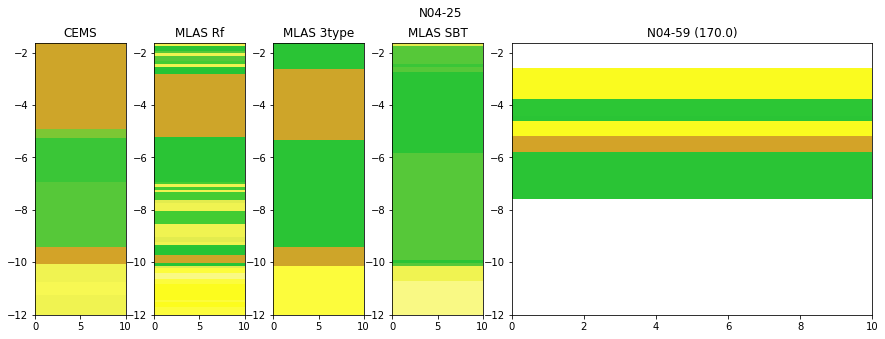

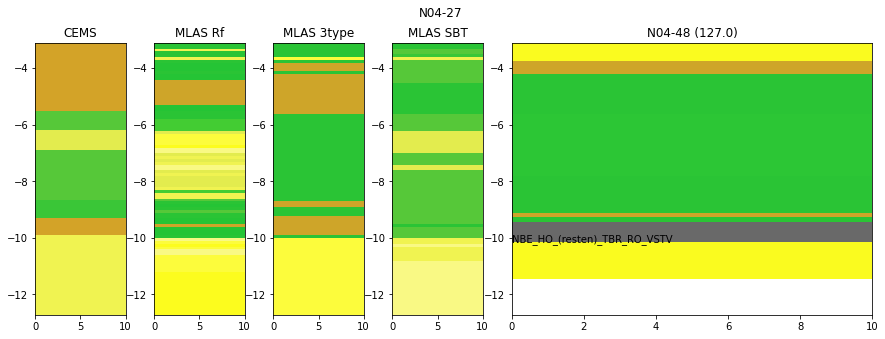

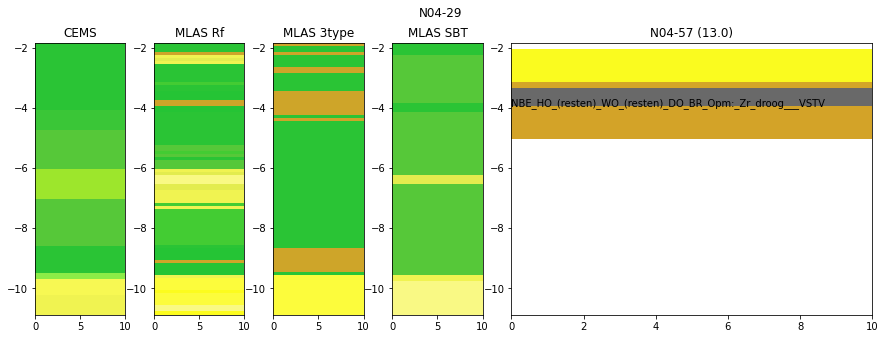

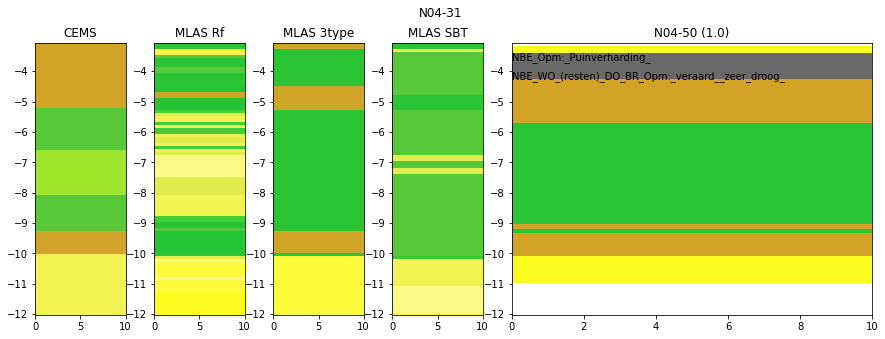

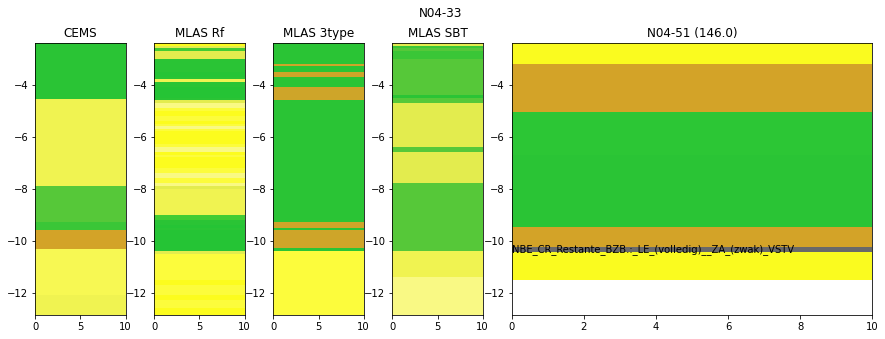

In [95]:
for cpt in mlas_cpts_crest:
    df = pd.read_csv(f"D:/_TEMP/P1011/{cpt.name}.csv")    
    soillayers_cems = [[s[0], s[1]] for s in zip(df.elevation_with_respect_to_NAP.values, df.soil_code.values)]
    soillayers_cems[0][0] += df.depth_top.values[0]    
    
    soillayers_mlas_nl_rf = [(sl.top, sl.soilcode) for sl in cpt.to_soillayers(cptconversionmethod = CPTConversionMethod.NL_RF)]
    soillayers_mlas_threetype = [(sl.top, sl.soilcode) for sl in cpt.to_soillayers(cptconversionmethod = CPTConversionMethod.THREE_TYPE_RULE)]
    soillayers_mlas_sbt = [(sl.top, sl.soilcode) for sl in cpt.to_soillayers(cptconversionmethod = CPTConversionMethod.SBT)]
    
    closest_borehole_info = sorted([(math.hypot(b.x - cpt.x, b.y - cpt.y), b) for b in mlas_boreholes_crest])[0]
        
    compare_plot(
        soillayers_cems, 
        soillayers_mlas_nl_rf, 
        soillayers_mlas_threetype, 
        soillayers_mlas_sbt,
        closest_borehole_info,
        cpt.bottom,
        cpt.name
    )

Same for the polder

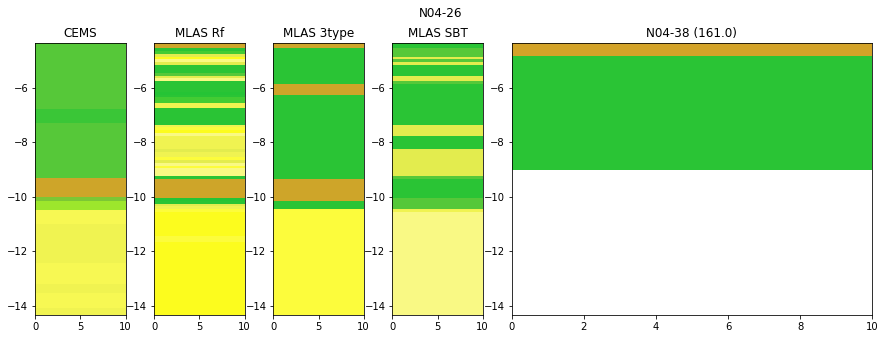

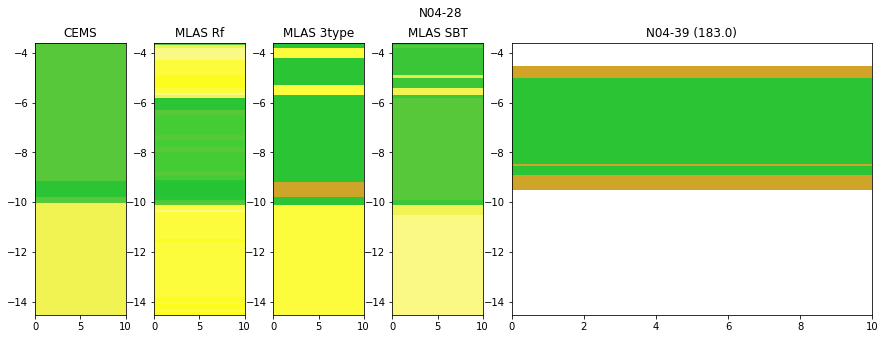

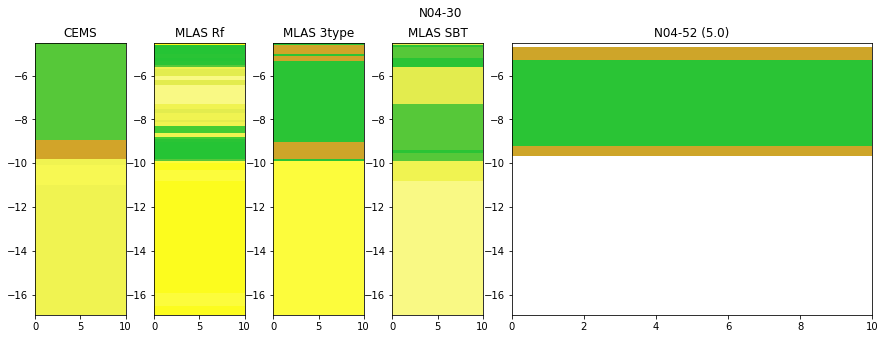

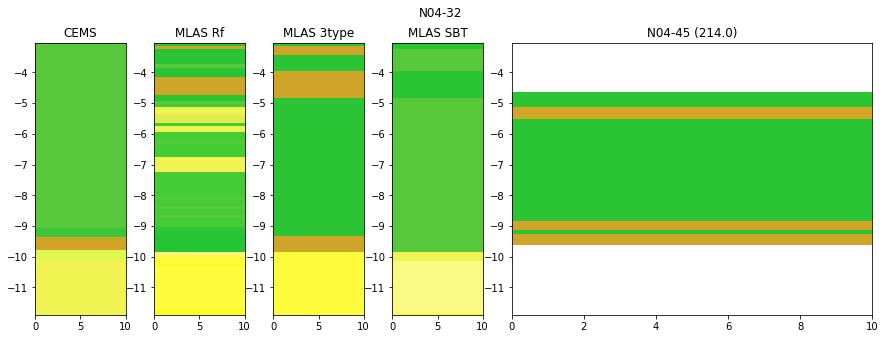

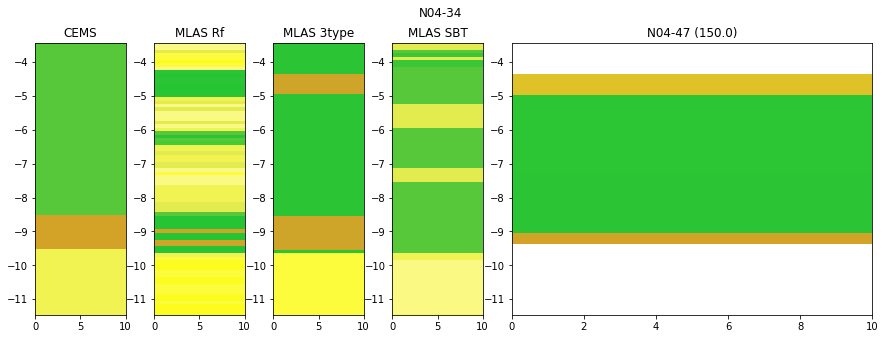

In [94]:
for cpt in mlas_cpts_polder:
    df = pd.read_csv(f"D:/_TEMP/P1011/{cpt.name}.csv")    
    soillayers_cems = [[s[0], s[1]] for s in zip(df.elevation_with_respect_to_NAP.values, df.soil_code.values)]
    soillayers_cems[0][0] += df.depth_top.values[0]
    
    soillayers_mlas_nl_rf = [(sl.top, sl.soilcode) for sl in cpt.to_soillayers(cptconversionmethod = CPTConversionMethod.NL_RF)]
    soillayers_mlas_threetype = [(sl.top, sl.soilcode) for sl in cpt.to_soillayers(cptconversionmethod = CPTConversionMethod.THREE_TYPE_RULE)]
    soillayers_mlas_sbt = [(sl.top, sl.soilcode) for sl in cpt.to_soillayers(cptconversionmethod = CPTConversionMethod.SBT)]
    
    closest_borehole_info = sorted([(math.hypot(b.x - cpt.x, b.y - cpt.y), b) for b in mlas_boreholes_polder])[0]
        
    compare_plot(
        soillayers_cems, 
        soillayers_mlas_nl_rf, 
        soillayers_mlas_threetype, 
        soillayers_mlas_sbt,
        closest_borehole_info,
        cpt.bottom,
        cpt.name
    )